In [1]:
import sys
sys.path.insert(0, '/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages')

import pandas as pd
import numpy as np
from astropy.table import Table
import FoFCatalogMatching
from GCR import GCRQuery
import GCRCatalogs

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
inputCatalog = GCRCatalogs.load_catalog('dc2_reference_run1.2p')
CoordinatesInputCat = inputCatalog.get_quantities(['ra','dec'])
raCoordinatesInputCat = CoordinatesInputCat['ra']
decCoordinatesInputCat = CoordinatesInputCat['dec']

Both frames are equal.


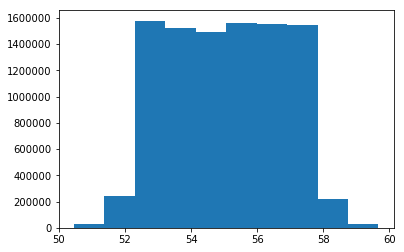

In [4]:
_=plt.hist(raCoordinatesInputCat)

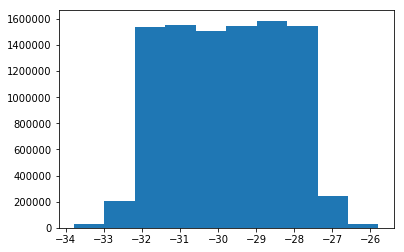

In [5]:
_=plt.hist(decCoordinatesInputCat)

In [6]:
racenter = 55.
rawidth = 0.5
deccenter = -30.
decwidth = 0.09
ndx1 = np.where(abs(raCoordinatesInputCat - racenter) < rawidth)[0]
raCoordinatesInputCat = raCoordinatesInputCat[ndx1]
decCoordinatesInputCat=decCoordinatesInputCat[ndx1]

In [7]:
inputCat = Table({'ra' : raCoordinatesInputCat, 'dec' : decCoordinatesInputCat})

In [8]:
outputCatalog = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')

../scripts/reader/dc2_static_coadd_reader.py:65: UserWarning: Cannot access /global/projecta/projectdirs/lsst/global/in2p3/Run1.1/summary/merged_tract_4639.hdf5; skipped
  warnings.warn('Cannot access {}; skipped'.format(fpath))
../scripts/reader/dc2_static_coadd_reader.py:65: UserWarning: Cannot access /global/projecta/projectdirs/lsst/global/in2p3/Run1.1/summary/merged_tract_4640.hdf5; skipped
  warnings.warn('Cannot access {}; skipped'.format(fpath))
../scripts/reader/dc2_static_coadd_reader.py:54: UserWarning: merged_tract_4849.hdf5 does not have correct group names; skipped
  warnings.warn('{} does not have correct group names; skipped'.format(fname))


In [9]:
tracts=outputCatalog.available_tracts
tracts.remove(4850)
#tracts=tracts[1:3]
print (len(tracts))
CoordinatesOutputCat=outputCatalog.get_quantities(['ra','dec','detect_isPrimary'],native_filters=[(lambda x: x in tracts, 'tract')])

16


In [11]:
raCoordinatesOutputCat = CoordinatesOutputCat['ra']/np.pi*180
decCoordinatesOutputCat = CoordinatesOutputCat['dec']/np.pi*180

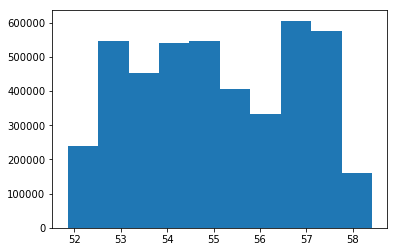

In [12]:
_=plt.hist(raCoordinatesOutputCat)

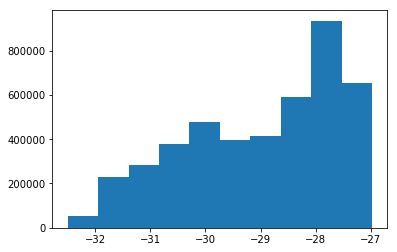

In [13]:
_=plt.hist(decCoordinatesOutputCat)

In [14]:
ndx1 = np.where((abs(raCoordinatesOutputCat - racenter) < rawidth)&(CoordinatesOutputCat['detect_isPrimary']))[0]
raCoordinatesOutputCat = raCoordinatesOutputCat[ndx1]
decCoordinatesOutputCat = decCoordinatesOutputCat[ndx1]

In [15]:
outputCat = Table({'ra' : raCoordinatesOutputCat, 'dec' : decCoordinatesOutputCat})

In [16]:
results = FoFCatalogMatching.match({'inputCatalog' : inputCat, 'outputCatalog' : outputCat}, {1.0: None, 1.0: None})

In [63]:
currentGroup = 0
nMax=10
hist2d=np.zeros((nMax,nMax))
rowListInput = []
rowListOutput = []
inputNdx={}
outputNdx={}

"""
for row, catalog, group in results:
    if currentGroup == group:
        if catalog == 'inputCatalog':
            rowListInput.append(row)
            tupI = (raCoordinatesInputCat[row], decCoordinatesInputCat[row])
            inputNdx[row] = tupI
        elif catalog == 'outputCatalog':
            rowListOutput.append(row)
            tupO = (raCoordinatesInputCat[row], decCoordinatesOutputCat[row])
            outputNdx[row] = tupO
    else:
        currentGroup += 1
print(rowListInput)
"""
for row, catalog, group in results:
    #print (row,catalog,group,rowListInput,rowListOutput)
    if (currentGroup != group):
        Nin,Nout=(len(rowListInput),len(rowListOutput))
        
        hist2d[Nin,Nout]+=1
        tup=(Nin,Nout)
        if tup not in inputNdx:
            # we see it for the first time
            inputNdx[tup]=[rowListInput]
            outputNdx[tup]=[rowListOutput]
        else:
            inputNdx[tup].append(rowListInput)
            outputNdx[tup].append(rowListOutput)
        rowListInput=[]
        rowListOutput=[]
        currentGroup = group
    if catalog == 'inputCatalog':
        rowListInput.append(row)
    elif catalog == 'outputCatalog':
        rowListOutput.append(row)

In [64]:
for a in inputNdx:
    inputNdx[a]=np.array(inputNdx[a])
    outputNdx[a]=np.array(outputNdx[a])

In [65]:
hist2d[1,0],hist2d[0,1]

(1380369.0, 707472.0)

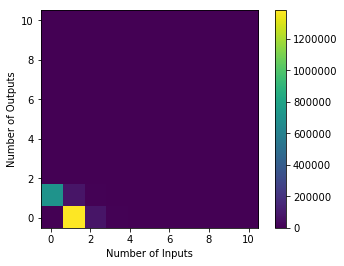

In [66]:
plt.imshow(hist2d.T, extent=(-0.5,nMax+0.5,-0.5,nMax+0.5),origin='lower')
plt.xlabel('Number of Inputs')
plt.ylabel('Number of Outputs')
plt.colorbar()
plt.savefig("#ItemsOutputs vs #ItemsInputs.png")
plt.show()

In [82]:
inputNdx[(1,1)][:,0].shape

(75567,)

In [86]:
deltara=raCoordinatesInputCat[inputNdx[(1,1)][:,0]]-raCoordinatesOutputCat[outputNdx[(1,1)][:,0]]
deltadec=decCoordinatesInputCat[inputNdx[(1,1)][:,0]]-decCoordinatesOutputCat[outputNdx[(1,1)][:,0]]


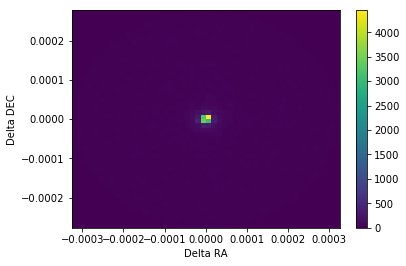

In [87]:
plt.hist2d(deltara,deltadec,bins=50)
plt.xlabel('Delta RA')
plt.ylabel('Delta DEC')
plt.colorbar()
plt.savefig("DeltaDECvsDeltaRA(non-logarithmic).png")
plt.show()

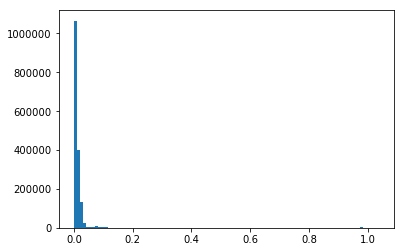

In [51]:
#Plotting Delta Phi for inputs
_=plt.hist(deltaPhiI,bins=100)

In [24]:
#Delta Phi comparing the outputs
raCoordinatesOutputCat = raCoordinatesOutputCat * (np.pi/180)
decCoordinatesOutputCat = decCoordinatesOutputCat * (np.pi/180)
decCoordinatesOutputCat = decCoordinatesInputCat[:75567]
deltaPhiO = []
for i in range(len(decCoordinatesOutputCat)):
    deltaPhiO.append(np.sqrt(np.square(dra[i] * np.cos(decCoordinatesOutputCat[i])) + 
                    np.square(ddec[i])))

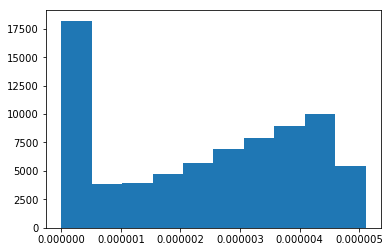

In [25]:
#Plotting Delta Phi for the outputs
_=plt.hist(deltaPhiO, bins=100)

In [48]:
MagnitudesInputCat = inputCatalog.get_quantities(['lsst_u', 'lsst_g', 'lsst_r', 'lsst_i',
                                                  'lsst_z', 'lsst_y'])

In [61]:
MagnitudesOutputCat = outputCatalog.get_quantities(['u_mag', 'g_mag', 'r_mag', 'i_mag',
                                                  'z_mag', 'y_mag'], 
                                                   native_filters=[(lambda x: x in tracts, 'tract')])

In [62]:
outputCatalog.list_all_native_quantities()

['r_base_SdssShape_xx',
 'u_modelfit_CModel_exp_flux',
 'g_base_PixelFlags_flag_saturatedCenter',
 'r_slot_ModelFlux_initial_apCorrSigma',
 'merge_peak_sky',
 'z_base_LocalBackground_flag_badCentroid',
 'ext_shapeHSM_HsmShapeBj_flag_badCentroid_almostNoSecondDerivative',
 'g_base_SdssCentroid_flag_resetToPeak',
 'u_modelfit_GeneralShapeletPsfApprox_DoubleShapelet_0_3',
 'z_deblend_nChild',
 'z_modelfit_GeneralShapeletPsfApprox_DoubleShapelet_1_xx',
 'r_modelfit_GeneralShapeletPsfApprox_DoubleShapelet_0_xy',
 'slot_ModelFlux_initial_time',
 'z_base_CircularApertureFlux_flag_badCentroid',
 'slot_ModelFlux_dev_fluxSigma',
 'g_base_CircularApertureFlux_50_0_flag_apertureTruncated',
 'ext_convolved_ConvolvedFlux_3_3_3_fluxSigma',
 'g_base_GaussianFlux_flag_badCentroid',
 'u_base_GaussianFlux_apCorrSigma',
 'z_slot_PsfShape_xy',
 'u_modelfit_DoubleShapeletPsfApprox_0_1',
 'slot_ModelFlux_initial_fixed_0',
 'base_PsfFlux_flag_badCentroid_noSecondDerivative',
 'r_slot_ModelFlux_flux',
 'u_mode

In [64]:
#Delta for U
inputU = MagnitudesInputCat['lsst_u']
outputU = MagnitudesOutputCat['u_mag']
print(inputU)
print(outputU)

[ 28.66167312  29.49670411  30.9869044  ...,  32.61145894  33.47970889
  31.46897716]
[ nan  nan  nan ...,  nan  nan  nan]
